# Parameter Estimation For X-ray Spectra in Pure Python

I'm going to show that you can do parameter estimation for X-ray spectra in pure python. 

This implementation is fairly rudimentary; this is because at the moment, we have no XSPEC models, and this doesn't take into account things like backgrounds and combined models. But technically, all of this is possible. We might extend this notebook in the future with more complex examples.

### Why Would I Do This?

I build statistical models, some of which are hierarchical and quite complex. As such, interfacing with existing X-ray spectroscopy tools is exceedingly difficult, because many things are either hard-coded, or simply not documented. 

This library is an attempt to build a few light-weight tools that can be easily combined to a more complex model without having to install XSPEC, ISIS or sherpa (and deal with the corresponding dependencies). At this point, `Clarsach` only depends on a few Python packages. More dependencies might follow as we add XSPEC models, but it currently includes a pure Python implementation of the code that applies responses to data. This is ~20 times faster than the C++ implementation, so watch out for us adding that later on.

With spectral-timing getting more and more traction, being able to combine spectral models with timing methods is becoming increasingly more important, and we're going to need these building blocks supplied in this package for continuing this work.

### What This Is Not

It is **not** a spectral fitting package. There are already three excellent packages out there, we don't really feel like we need to reinvent the wheel. This library *only* supplies some basic tools that are crucial for building new spectral models (statistical models, that is, not physical ones). You can build your own model out of this following some of the code we've supplied below, or build even more complex tools; it's up to you. We don't aim to supply a full solution, just the building blocks. You'll have to do the actual building yourself.

## Let's get started: Chandra/ACIS 1-D Spectral Modelling

We're going to use a simulated spectrum of a pure power law, since we don't currently have an interface XSPEC spectral models. 
We have a simulated *Chandra*/ACIS spectrum in this repo for you to use. 

Let's first load some packages we'll need:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    print("No seaborn installed. Oh well.")
    
import numpy as np 
from scipy.special import gammaln as scipy_gammaln
import scipy.stats

import astropy.io.fits as fits
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params

from clarsach import respond
from clarsach.spectrum import XSpectrum
from clarsach.models.powerlaw import Powerlaw

Let's load the actual data. We're going to use `astropy` to do that:

In [2]:
phafile = "./fake_acis.pha"

pha_list = fits.open(phafile)

Since this is Chandra data, we know where all the relevant information is:

In [3]:
bin_lo = pha_list[1].data.field("BIN_LO")
bin_hi = pha_list[1].data.field("BIN_HI")
bin_mid = bin_lo + (bin_hi - bin_lo)/2.

channels = pha_list[1].data.field("CHANNEL")
counts = pha_list[1].data.field("COUNTS")

In [4]:
respfile = pha_list[1].header["RESPFILE"]
arffile = pha_list[1].header["ANCRFILE"]

Let's plot the raw spectrum:

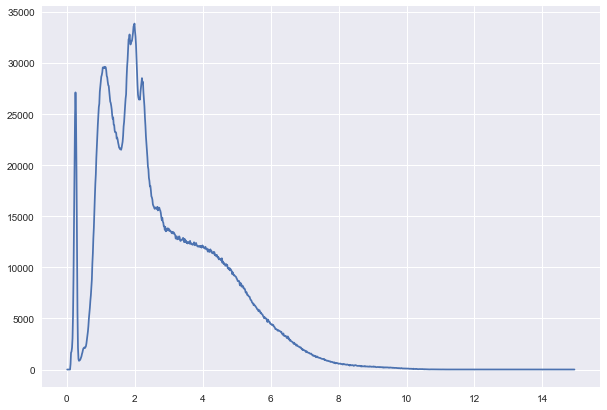

In [5]:
plt.figure()
plt.figure(figsize=(10,7))
plt.plot(bin_mid, counts)

Ok, great! Now we can load the ARF and RMF:

In [6]:
arf = respond.ARF(arffile)
rmf = respond.RMF(respfile)

There's also an `XSPECTRUM` class that makes all of this much easier:

In [7]:
spec = XSpectrum(phafile)

`spec` now also contains the ARF and RMF and can be used for various things.

Ok, cool. Because we currently don't have access to the XSPEC models, we've defined a simple Python model for a power law. The key here is that these models need to *integrate* over each bin in order to yield the correct result. Let's make a `Powerlaw` object so we can use it in model fitting:

In [8]:
pl_model = Powerlaw(norm=1., phoindex=2.0)

In [9]:
y_truth = pl_model.calculate(rmf.energ_lo, rmf.energ_hi)
y_arf = y_truth * arf.specresp
y_rmf = rmf.apply_rmf(y_arf)

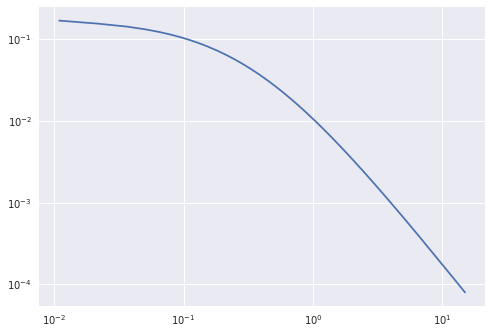

In [10]:
plt.figure()
plt.loglog(bin_mid, y_truth)

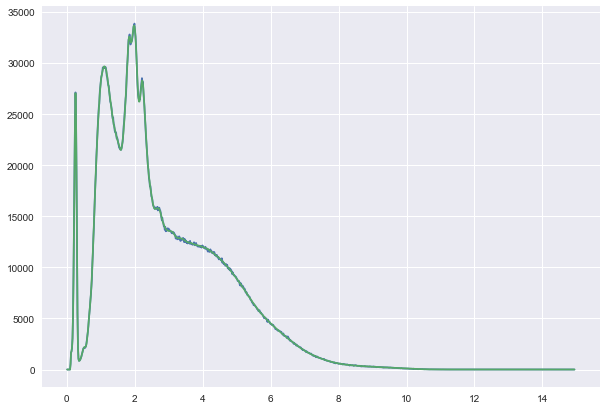

In [11]:
plt.figure()
plt.figure(figsize=(10,7))
plt.plot(bin_mid, counts)
plt.plot(bin_mid, y_rmf*1e5)

### Spectral Fitting

In order to do spectral fitting, we need a **likelihood** function. The likelihood defines the statistical model, i.e. how the model relates to the data and its uncertainties. 

We are going to use a Poisson likelihood here, since we're looking at photon counting data. Instead of a likelihood, we're actually going to define a **posterior**, so we're going to include some fairly broad priors. But we'll need that for the MCMC stuff below.

Let's define a class for this, which will make things much easier later on:

In [12]:
class PoissonPosterior(object):
    
    def __init__(self, spec, model):
        self.x_low = spec.rmf.energ_lo
        self.x_high = spec.rmf.energ_hi
        self.y = spec.counts
        self.model = model
        self.arf = spec.arf
        self.rmf = spec.rmf
        self.exposure = spec.exposure

    def logprior(self, pars):
        
        phoind = pars[0]
        norm = pars[1]
        
        p_ph = scipy.stats.uniform(1.0, 4.0).logpdf(phoind)
        p_norm = scipy.stats.uniform(0, 10).logpdf(norm)
        return p_ph + p_norm
        
    def _calculate_model(self, pars):
        
        self.model.phoindex = pars[0]
        self.model.norm = pars[1]
        
        # evaluate the model at the positions x
        mean_model = self.model.calculate(self.x_low, self.x_high)

        # run the ARF and RMF calculations
        if self.arf is not None:
            m_arf = self.arf.apply_arf(mean_model)
        else:
            m_arf = mean_model
            
        if self.rmf is not None:
            ymodel = self.rmf.apply_rmf(m_arf)
        else:
            ymodel = mean_model
        
        ymodel *= self.exposure
        ymodel += 1e-20
        
        return ymodel

    def loglikelihood(self, pars):
        
        ymodel = self._calculate_model(pars)
        
        # compute the log-likelihood
        loglike = np.sum(-ymodel + self.y*np.log(ymodel) \
               - scipy_gammaln(self.y + 1.))

        if np.isfinite(loglike):
            return loglike
        else:
            return -np.inf

    def logposterior(self, pars):
        return self.logprior(pars) + self.loglikelihood(pars)
        
    def __call__(self, pars):
        return self.logposterior(pars)

Awesome! Let's make a `LogPosterior` object that we can now play around with:

In [13]:
lpost = PoissonPosterior(spec, pl_model)

Because this is a simulated spectrum, we know the "ground truth" values. The photon index is $\Gamma = 2$, and the normalization is $N = 1$.

In [14]:
lpost([2,1])

-4050.5124165148268

Ok, cool. Fitting can be performed using `scipy.optimize`. 

Note that we've defined the posterior probability distribution such that we're looking for a maximum (as we usually do), but optimizers always search for a **minimum**. We'll make a little function that returns the -logposterior instead: 

In [15]:
lpost_neg = lambda pars : -lpost(pars)

In [16]:
lpost_neg([2, 1])

4050.5124165148268

In [17]:
lpost_neg([1.5, 3])

3659653.7974574277

Awesome, that works, too. Let's now stick this into `scipy.optimize` and look for a solution:

In [18]:
res = scipy.optimize.minimize(lpost_neg, [2, 1], method="L-BFGS-B")

In [19]:
res.x

array([ 2.,  1.])

In [20]:
res

      fun: 4050.5124165148268
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 2.,  1.])

In [21]:
y_truth = lpost._calculate_model([2,1])
y_fit = lpost._calculate_model(res.x)

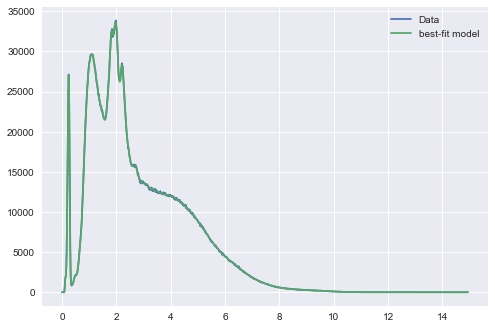

In [22]:
plt.figure()
plt.plot(spec.bin_lo, spec.counts, label="Data")
#plt.plot(spec.bin_lo, y_truth, label="ground truth")
plt.plot(spec.bin_lo, y_fit, label="best-fit model")
plt.legend()

Hooray, we can fit! That's the minimum result we were looking for!

But we can do more! For example, we might be interested in the probability distribution of the parameters. For that, let's actually fire up MCMC and use `emcee` to sample the probability distributions:

In [23]:
import emcee

In [24]:
res.x

array([ 2.,  1.])

In [25]:
ndim = 2
nwalker = 500
burnin = 200
niter = 200

p0 = np.array([np.random.multivariate_normal(res.x, 
                                             np.diag([0.05, 0.05])) for i in range(nwalker)])

In [26]:
sampler = emcee.EnsembleSampler(nwalker, ndim, lpost, threads=4)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in log
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in log
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in log
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in log


In [27]:
pos, prob, stat = sampler.run_mcmc(p0, burnin)

In [ ]:
sampler.reset()

_, _, _ = sampler.run_mcmc(pos, niter, rstate0=stat)